### Feed-forward coordinate prediction (DualOutput)

In [1]:
'''
Imports external and own libraries
'''

import pickle

import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader

from prettytable import PrettyTable

# own
import collector
import action
import world
import plot
import preprocess
import nets
import train

/Users/mariuskaestingschaefer/miniforge3/envs/pytorch/lib/python3.8/site-packages/seaborn/rcmod.py:82: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/Users/mariuskaestingschaefer/miniforge3/envs/pytorch/lib/python3.8/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/Users/mariuskaestingschaefer/miniforge3/envs/pytorch/lib/python3.8/site-packages/torch/utils/tensorboard/__init__.py:6: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, '__version__') or LooseVersion(tensorboard.__version__) < LooseVersion('1.15'):


In [91]:
'''
Load data with pickle (deserialize)
'''
with open('datasets/oracle_data.pickle', 'rb') as handle:
    oracle_data = pickle.load(handle)

with open('datasets/oracle_reversed_data.pickle', 'rb') as handle:
    oracle_reversed_data = pickle.load(handle)

with open('datasets/oracle_random_data.pickle', 'rb') as handle:
    oracle_random_data = pickle.load(handle)

with open('datasets/oracle_reversed_random_data.pickle', 'rb') as handle:
    oracle_reversed_random_data = pickle.load(handle)
    
with open('datasets/random_data.pickle', 'rb') as handle:
    random_data = pickle.load(handle)

with open('datasets/tmaze_random_reverse_data.pickle', 'rb') as handle:
    tmaze_random_reverse_data = pickle.load(handle)
    
with open('datasets/oracle_reversed_random_data_small.pickle', 'rb') as handle:
    oracle_reversed_random_data_small = pickle.load(handle)

In [100]:
pred_coordinates = nets.DualOutput()
summary(pred_coordinates, (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
         MaxPool2d-2            [-1, 6, 14, 14]               0
            Conv2d-3           [-1, 16, 10, 10]           2,416
         MaxPool2d-4             [-1, 16, 5, 5]               0
            Linear-5                  [-1, 120]          48,120
            Linear-6                   [-1, 84]          10,164
            Linear-7                    [-1, 1]              85
            Linear-8                  [-1, 120]          48,120
            Linear-9                   [-1, 84]          10,164
           Linear-10                    [-1, 1]              85
Total params: 119,610
Trainable params: 119,610
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.06
Params size (MB): 0.46
Estimated T

In [101]:
train_data, test_data = preprocess.split_data(tmaze_random_reverse_data, 0.8)

# preprocess trainingset 
oracle_train_data = preprocess.ObtainDataset(train_data, 'observations', 'positions')
oracle_test_data = preprocess.ObtainDataset(test_data, 'observations', 'positions')

In [102]:
'''
Use Dataloader to make the data ready for the training loop
'''
train_data, test_data = preprocess.split_data(oracle_reversed_data, 0.8)

# preprocess trainingset 
oracle_train_data = preprocess.ObtainDataset(train_data, 'observations', 'positions')
oracle_test_data = preprocess.ObtainDataset(test_data, 'observations', 'positions')

# build dataloader (tensor format)
batch_size = 128
dataset_loader_train_data = DataLoader(oracle_train_data, batch_size=batch_size, shuffle=True)
dataset_loader_test_data = DataLoader(oracle_test_data, batch_size=batch_size, shuffle=True)

Progress:   0%|          | 0/500 [00:00<?, ? Episode/s]

Epoch: 1, Train Loss: 479.3, Train Acc: 1.308 %,  Test Loss: 417.4, Test Acc: 3.661 %,
Epoch: 11, Train Loss: 99.18, Train Acc: 4.106 %,  Test Loss: 98.51, Test Acc: 2.406 %,
Epoch: 21, Train Loss: 97.48, Train Acc: 4.079 %,  Test Loss: 96.74, Test Acc: 3.452 %,
Epoch: 31, Train Loss: 96.79, Train Acc: 5.387 %,  Test Loss: 94.25, Test Acc: 6.799 %,
Epoch: 41, Train Loss: 95.29, Train Acc: 6.773 %,  Test Loss: 93.72, Test Acc: 7.008 %,
Epoch: 51, Train Loss: 93.67, Train Acc: 5.753 %,  Test Loss: 92.29, Test Acc: 3.766 %,
Epoch: 61, Train Loss: 92.48, Train Acc: 5.884 %,  Test Loss: 90.82, Test Acc: 6.485 %,
Epoch: 71, Train Loss: 92.07, Train Acc: 4.759 %,  Test Loss: 90.25, Test Acc: 6.172 %,
Epoch: 81, Train Loss: 90.38, Train Acc: 5.099 %,  Test Loss: 90.19, Test Acc: 3.766 %,
Epoch: 91, Train Loss: 88.96, Train Acc: 5.988 %,  Test Loss: 88.03, Test Acc: 5.439 %,
Epoch: 101, Train Loss: 87.53, Train Acc: 4.576 %,  Test Loss: 88.0, Test Acc: 3.661 %,
Epoch: 111, Train Loss: 86.38, Tr

/Users/mariuskaestingschaefer/miniforge3/envs/pytorch/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


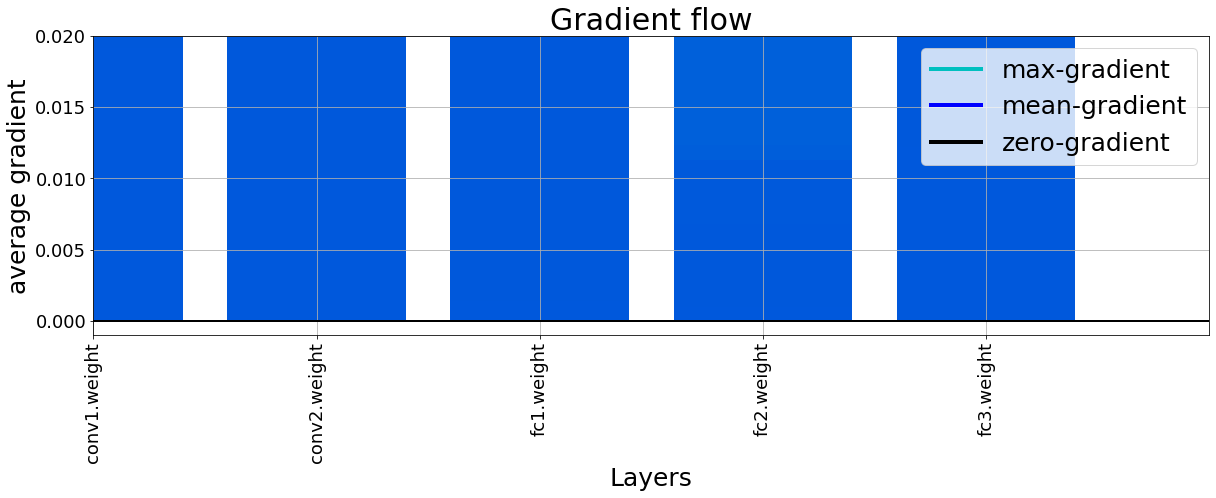

In [103]:
'''
Train the network
- obtained with RMS, lr=0.0005, 200 episodes: train acc. 4% (73 loss), test acc. 4%
- obtained with RMS, lr=0.0005, 300 episodes: train acc. 5% (60 loss), test acc. 6%
- obtained with RMS, lr=0.0005, 400 episodes: train acc. 6% (56 loss), test acc. 6%

- what with a lr. of 0.001?
Learning then stagnates; decrease learning rate?
Change weight initialization?
'''

criterion = nn.MSELoss() # CrossEntropyLoss
optimizer = optim.Adam(pred_coordinates.parameters(), lr=0.001) # RMSprop, Adam, SGD

episodes = 500
pred_coordinates, train_loss, test_loss, train_acc, test_acc, train_dis, test_dis, train_dis_item, test_dis_item  = train.DualOutput(dataset_loader_train_data, 
                                                                                                                                      dataset_loader_test_data, 
                                                                                                                                      pred_coordinates, criterion, 
                                                                                                                                      optimizer, episodes)


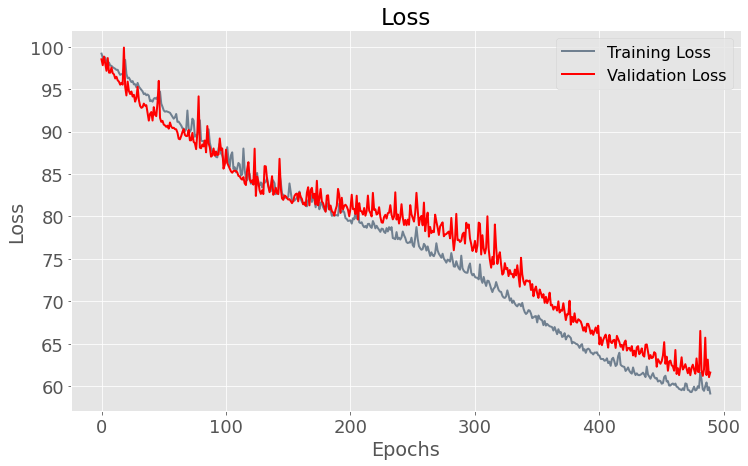

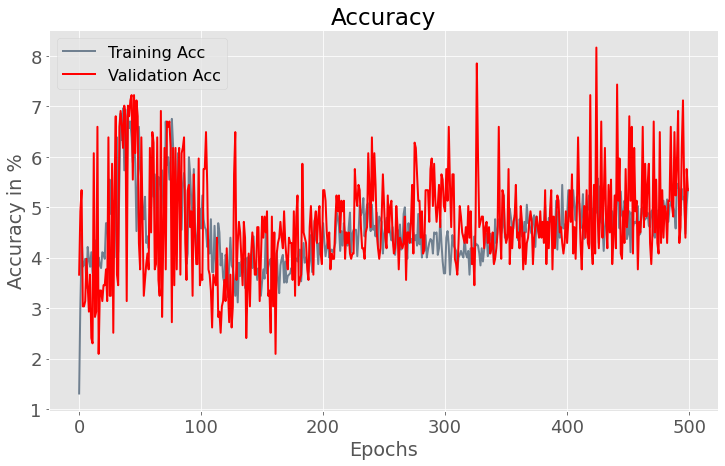

In [104]:
'''
Plot loss and accuracy curves for training and test set
'''

plot.plot_losses(train_loss[10:], test_loss[10:])
plot.plot_acc(train_acc, test_acc, smooth=False)

In [105]:
train_dis_notensor  = []
for i in train_dis:
    i = i.detach().numpy()
    i = i.item()
    train_dis_notensor.append(i)
    
train_dis_item_notensor  = []
for i in train_dis_item:
    i = i.detach().numpy()
    train_dis_item_notensor.extend(i)

test_dis_item_notensor  = []
for i in test_dis_item:
    i = i.detach().numpy()
    test_dis_item_notensor.extend(i)

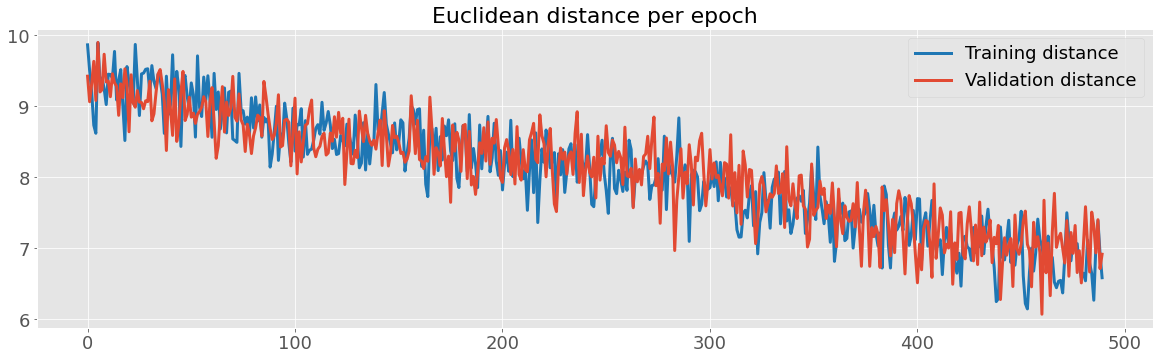

In [112]:
# why are distance and loss so different here?

import torch

from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = 20, 5.5
    
with plt.style.context('ggplot'):
    plt.plot(train_dis_notensor[10:], label = "Training distance", linewidth=3, color='tab:blue')
    plt.plot(test_dis[10:], label = "Validation distance", linewidth=3)
    plt.title('Euclidean distance per epoch', fontsize=22)
    plt.legend(fontsize=18)
    plt.show()

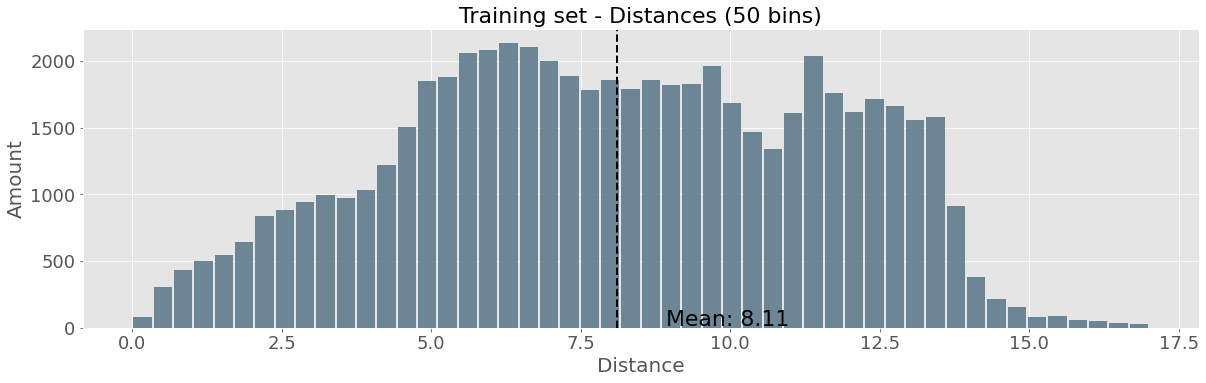

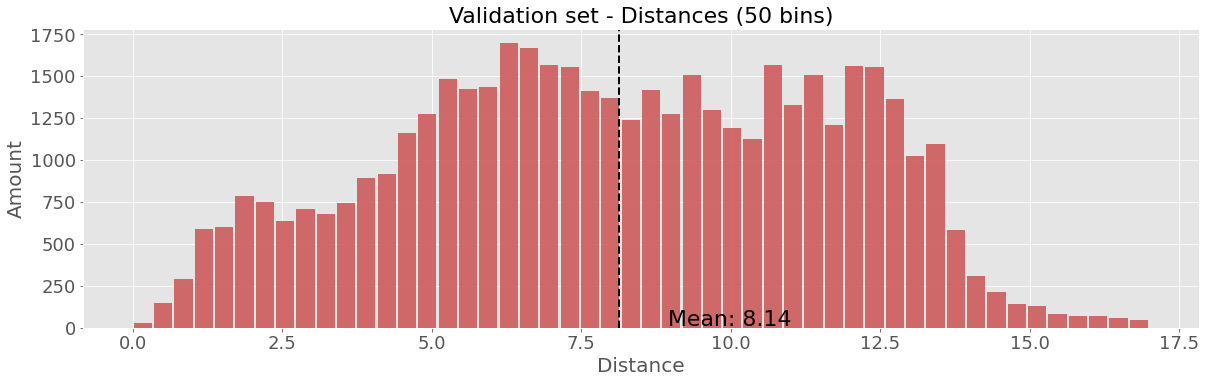

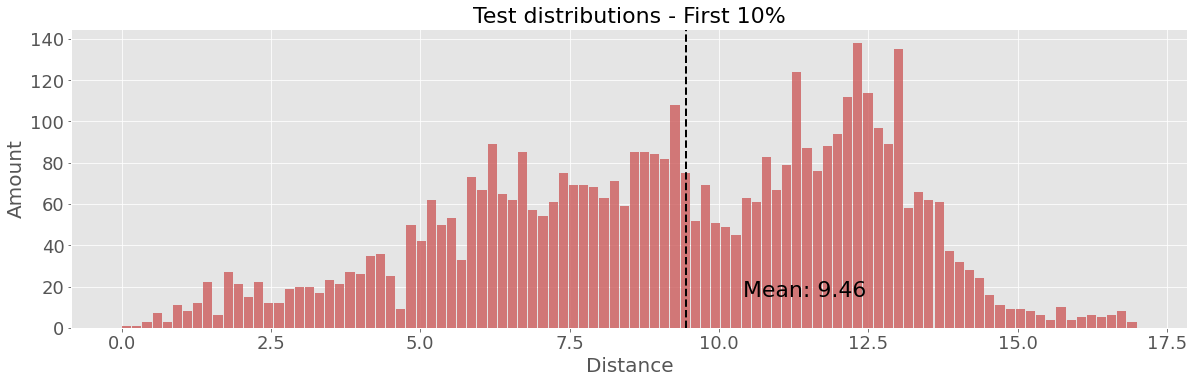

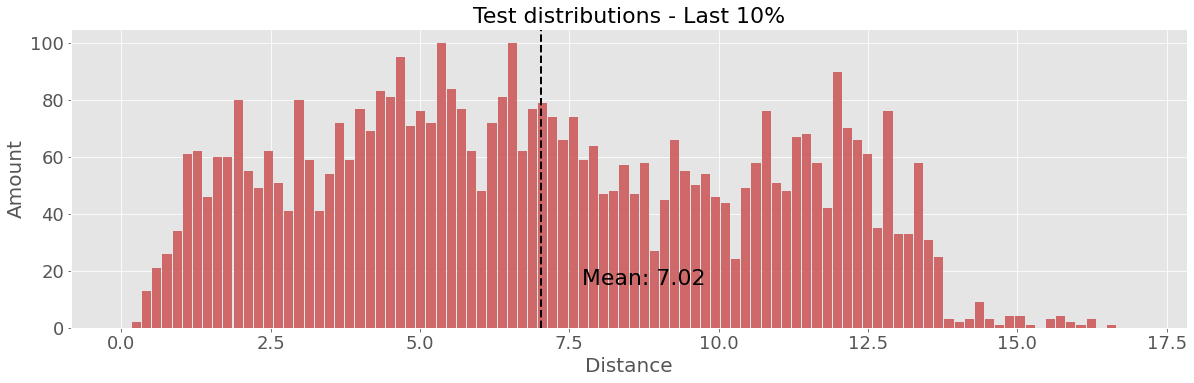

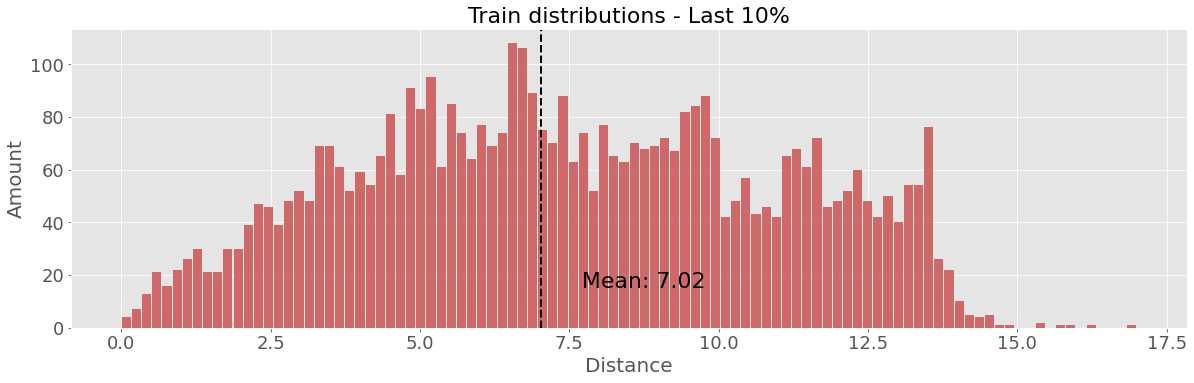

In [117]:
import statistics

plt.rcParams['figure.figsize'] = 20, 5.5
plt.rcParams.update({'font.size': 25})
plt.rc('xtick', labelsize=18) 
plt.rc('ytick', labelsize=18)

with plt.style.context('ggplot'):
    max_lim = 17
    plt.hist(train_dis_item_notensor[10:], bins=50, rwidth=0.9, color='#607c8e', range=(0, max_lim), alpha=0.9)
    plt.xlabel('Distance', fontsize=20)
    plt.ylabel('Amount', fontsize=20)
    plt.title('Training set - Distances (50 bins)', fontsize=22)
    mean_val = statistics.mean(train_dis_item_notensor[10:])
    plt.text(mean_val*1.1, max_lim*0.9, 'Mean: {:.2f}'.format(mean_val), fontsize=22)
    plt.axvline(mean_val, color='k', linestyle='dashed', linewidth=2)
    plt.show()

with plt.style.context('ggplot'):
    plt.hist(test_dis_item_notensor[10:], bins=50, rwidth=0.9, color='indianred', range=(0, 17), alpha=0.9)
    plt.xlabel('Distance', fontsize=20)
    plt.ylabel('Amount', fontsize=20)
    plt.title('Validation set - Distances (50 bins)', fontsize=22)
    mean_val = statistics.mean(test_dis_item_notensor[10:])
    plt.text(mean_val*1.1, max_lim*0.9, 'Mean: {:.2f}'.format(mean_val), fontsize=22)
    plt.axvline(mean_val, color='k', linestyle='dashed', linewidth=2)
    plt.show()

length = len(test_dis_item_notensor)

with plt.style.context('ggplot'):
    plt.hist(test_dis_item_notensor[0:int(length*0.1)], bins=100, rwidth=0.9, color='indianred', range=(0, 17), alpha=0.8)
    plt.title('Test distributions - First 10%', fontsize=22)
    plt.xlabel('Distance', fontsize=20)
    plt.ylabel('Amount', fontsize=20)
    mean_val = statistics.mean(test_dis_item_notensor[10:int(length*0.1)])
    plt.text(mean_val*1.1, max_lim*0.9, 'Mean: {:.2f}'.format(mean_val), fontsize=22)
    plt.axvline(mean_val, color='k', linestyle='dashed', linewidth=2)
    plt.show()

with plt.style.context('ggplot'):
    plt.hist(test_dis_item_notensor[int(length*0.9):length-1], bins=100, rwidth=0.9, color='indianred', range=(0, 17), alpha=0.9)
    plt.title('Test distributions - Last 10%', fontsize=22)
    plt.xlabel('Distance', fontsize=20)
    plt.ylabel('Amount', fontsize=20)
    mean_val = statistics.mean(test_dis_item_notensor[int(length*0.9):length-1])
    plt.text(mean_val*1.1, max_lim*0.9, 'Mean: {:.2f}'.format(mean_val), fontsize=22)
    plt.axvline(mean_val, color='k', linestyle='dashed', linewidth=2)
    plt.show()
    
with plt.style.context('ggplot'):
    plt.hist(train_dis_item_notensor[int(length*0.9):length-1], bins=100, rwidth=0.9, color='indianred', range=(0, 17), alpha=0.9)
    plt.title('Train distributions - Last 10%', fontsize=22)
    plt.xlabel('Distance', fontsize=20)
    plt.ylabel('Amount', fontsize=20)
    mean_val = statistics.mean(test_dis_item_notensor[int(length*0.9):length-1])
    plt.text(mean_val*1.1, max_lim*0.9, 'Mean: {:.2f}'.format(mean_val), fontsize=22)
    plt.axvline(mean_val, color='k', linestyle='dashed', linewidth=2)
    plt.show()

AttributeError: 'tuple' object has no attribute 'set_canvas'

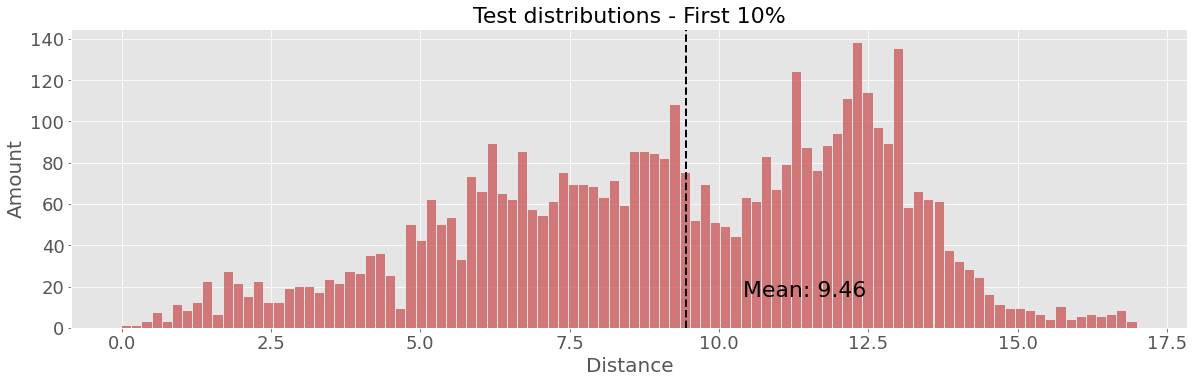

In [111]:
from moviepy.video.io.bindings import mplfig_to_npimage

def make_histogram(start, end):
    
    mean_val = statistics.mean(test_dis_item_notensor[start:end])
    max_lim = 17

    with plt.style.context('ggplot'):
        fig = plt.hist(test_dis_item_notensor[start:end], bins=100, rwidth=0.9, color='indianred', range=(0, max_lim), alpha=0.8)
        plt.title('Test distributions - First 10%', fontsize=22)
        plt.xlabel('Distance', fontsize=20)
        plt.ylabel('Amount', fontsize=20)
        plt.text(mean_val*1.1, max_lim*0.9, 'Mean: {:.2f}'.format(mean_val), fontsize=22)
        plt.axvline(mean_val, color='k', linestyle='dashed', linewidth=2)
        
        numpy_fig = mplfig_to_npimage(fig)
        
        return numpy_fig

current_histo = make_histogram(10, int(length*0.1))    

print(current_histo)

plt.imshow(current_histo)

#.show()

#start 10 - step int(length*0.1) - end

In [10]:
'''
Save and load model
'''
import torch 

torch.save(net, 'models/DualOutput2.pt')

NameError: name 'net' is not defined